In [1]:
## Ne pas executer à l'intérieur de Visual Studio Code
# %matplotlib notebook
## A l'intérieur de Google Colab, utiliser plutôt
# %matplotlib inline

# Mathematical morphology Segmentation Tutorial

Hugues Talbot, 2023 April 11

## Introduction to numpy, scipy, matplotlib, scikit-image

The main "modern" packages to perform image processing in python are

- numpy
- scipy
- matplotlib
- scikit-image

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import skimage

In [3]:
### To help viewing images

import numpy as np
import matplotlib.pyplot as plt


## to view a single image
def imview(image, cmap="gray", interpolation="nearest",figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(image,cmap=cmap, interpolation=interpolation)
    plt.axis('off')
    plt.show()
    
## to view 3 images at once
def viewlist(images,cmap="gray", figsize=(18,6)):
    plt.figure(figsize=(18,6))
    columns = len(images)
    for i, image in enumerate(images):
        plt.subplot(1, columns, i + 1)
        plt.imshow(image,cmap=cmap)
        plt.axis('off')
    plt.show()

In [4]:
## constructing a random color map for segmentation display

from matplotlib import colors

r=np.random.rand ( 256,3)
r[0]=[0,0,0]

randcmap = colors.ListedColormap (r)

## basics of numpy

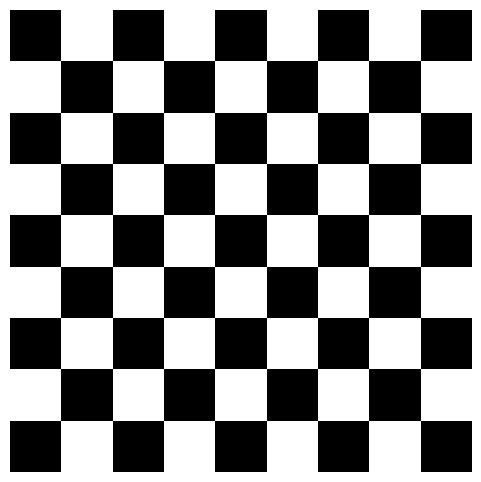

In [5]:
check = np.zeros((9, 9))
check[::2, 1::2] = 1
check[1::2, ::2] = 1
imview(check, cmap='gray', interpolation='nearest')

## scikit-image

scikit image contains many state-of-the-art image processing methods

https://scikit-image.org/

In [6]:
from skimage import data

In [7]:
camera = data.camera()
print("Image type", camera.dtype)
print("Image shape", camera.shape)

from skimage import restoration

Image type uint8
Image shape (512, 512)


### Mathematical morphology with scikit-image

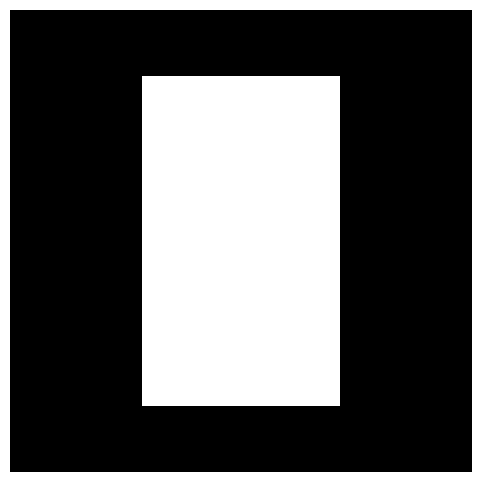

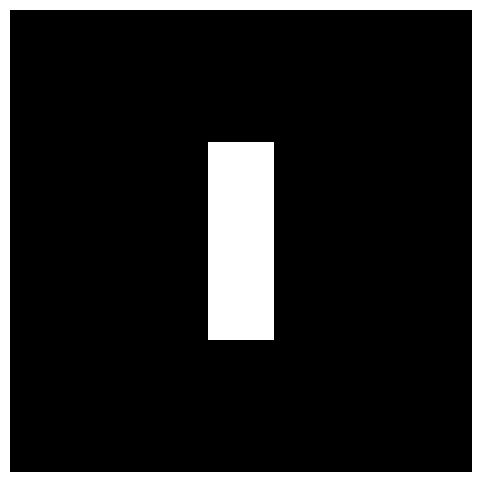

In [8]:
from skimage import morphology

## a structuring element.
morphology.disk(5)

## example on a tiny image
a = np.zeros((7,7), dtype=np.int32)
a[1:6, 2:5] = 1

imview(a)

ae = morphology.erosion(a, morphology.diamond(1)).astype(np.uint8) ## pour garder l'image codée en 8-bit

imview(ae)

## Basic operators

Try the same with dilation, openings and closings

In [9]:
### Your code here

### Greyscale morphology

In [10]:
from skimage.morphology import disk
from skimage import filters

coins = data.coins()
coins_zoom = coins[10:80, 300:370]
median_coins = filters.rank.median(coins_zoom, disk(1)) ## classical median filter
from skimage import restoration
tv_coins = restoration.denoise_tv_chambolle(coins_zoom, weight=0.05)
gaussian_coins = filters.gaussian(coins_zoom, sigma=2)

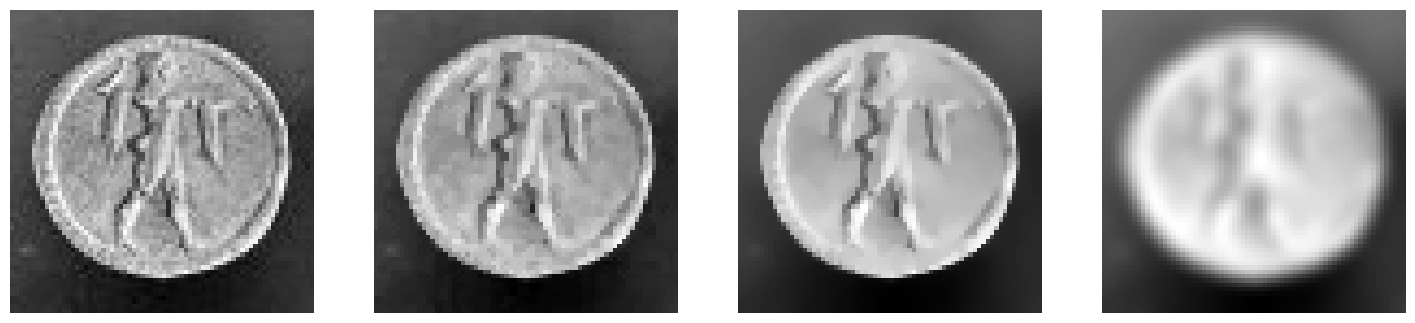

In [11]:
viewlist((coins_zoom,median_coins,tv_coins,gaussian_coins))

## opérateurs de MM en niveaux de gris

testez erosion / dilatation / ouverture / fermeture sur image de la pièce de monnaie 
et comparez (visuellement avec le filtre gaussien et médian.

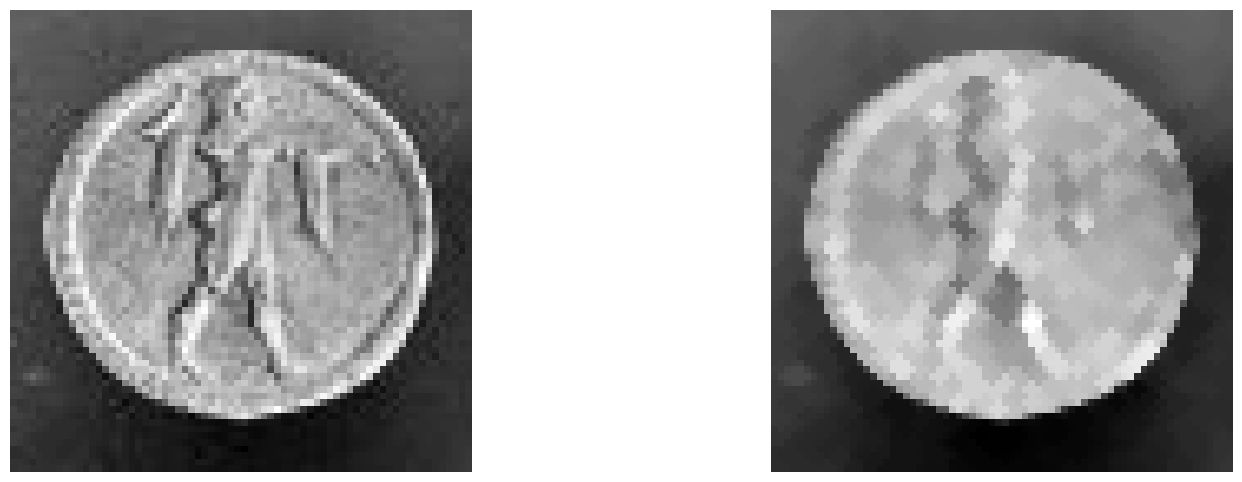

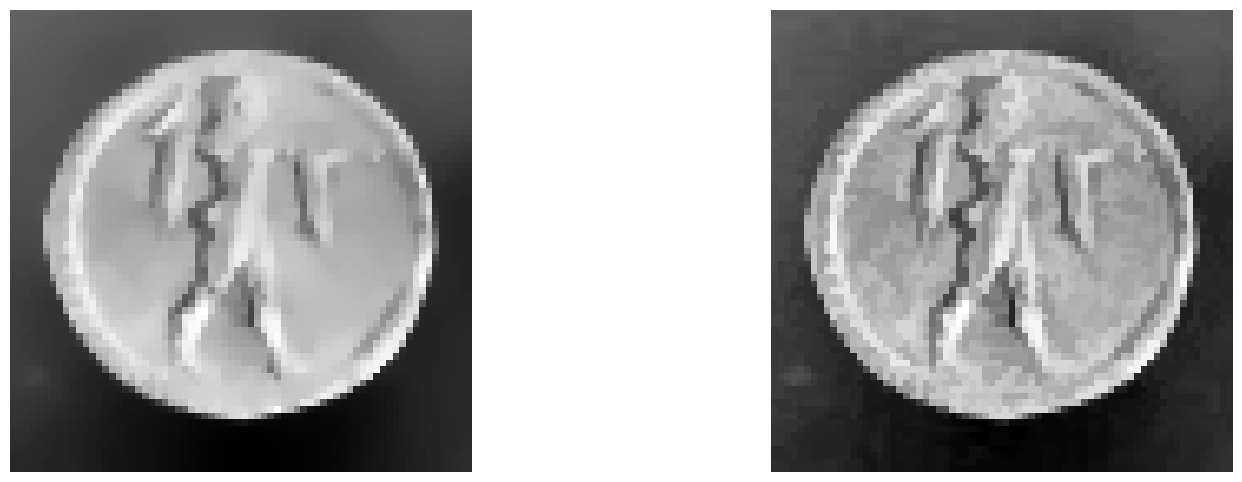

In [12]:
## votre code ici

coins_open = morphology.opening(coins_zoom, morphology.diamond(1))
coins_cloopen = morphology.closing(coins_open, morphology.diamond(1))

viewlist((coins_zoom, coins_cloopen))

## pareil, ouverture/fermeture par SE trop "violent"

coins_areaopen = morphology.area_opening(coins_zoom,4)
coins_areaclopen = morphology.area_closing(coins_areaopen,4)

viewlist((tv_coins, coins_areaclopen))

## Image segmentation

Image type:  <class 'numpy.ndarray'>


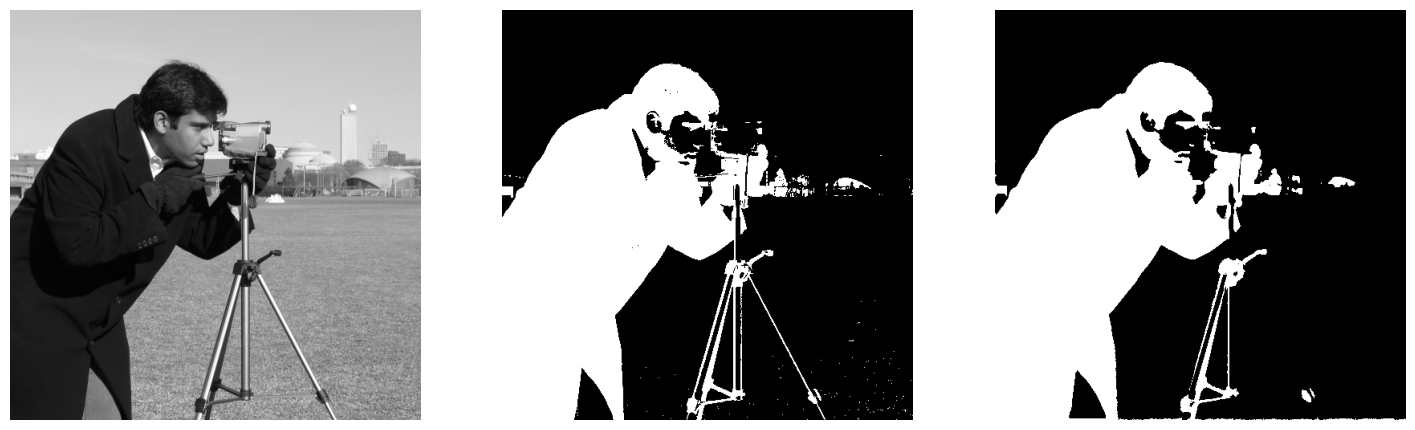

In [13]:
## Simplest segmentation method: thresholding

from skimage import data
from skimage import filters
camera = data.camera()
otsuval = filters.threshold_otsu(camera)

## filtrage par filtre bilatéral
filtered_camera = (restoration.denoise_bilateral(camera)*255).astype(np.uint8)
print("Image type: ", type(filtered_camera))

bincam = (camera < otsuval).astype(np.uint8)
bintvcam = (filtered_camera < otsuval).astype(np.uint8)

viewlist((camera,bincam,bintvcam))
## On constate que le filtrage bilatéral fait disparaitre des objets fins et allongés, en plus du bruit.

On constate que le filtrage bilatéral fait disparaitre des objets fins et allongés, en plus du bruit.

(718, 782)
Threshold at  79


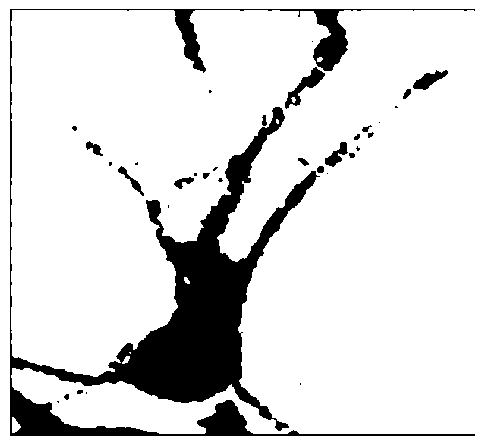

In [14]:
## Exemple sur l'image de neurones

neurons = skimage.io.imread("images/Neuron.png")
neurons = neurons[:,:,0]
print(neurons.shape)

otsuneuronval = filters.threshold_otsu(neurons)
print("Threshold at ", otsuneuronval)
#binneurons = (neurons < otsuneuronval-30).astype(np.uint8)
imview((neurons < 40).astype(np.uint8))

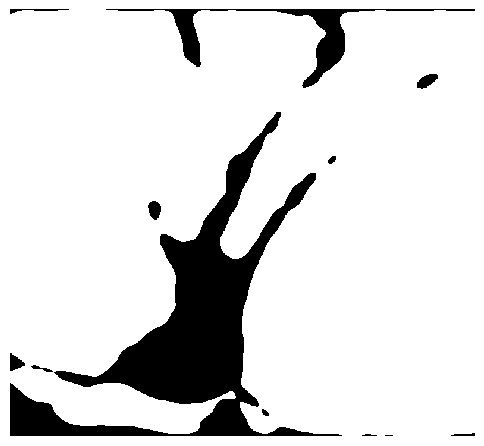

In [15]:
tv_neurons = (restoration.denoise_tv_chambolle(neurons, weight=1)*255).astype(np.uint8)
bintvneurons = (tv_neurons < 40).astype(np.uint8)
imview(bintvneurons)

## On voit que la TV a le même comportement, c'est un problème difficile.

On voit que la TV a le même comportement, c'est un problème difficile.
On étudiera ce problème un peu plus tard (mini-projet)

## Données synthétiques

In [21]:
n = 20
l = 256

def make_blobs(l, n, sigmadiv=4.0):
    im = np.zeros((l, l))
    points = l * np.random.random((2, n ** 2))
    im[(points[0]).astype(np.int32), (points[1]).astype(np.int32)] = 1
    im = filters.gaussian(im, sigma=l / (sigmadiv * n))
    blobs = im > im.mean()
    return(blobs)

blobs = make_blobs(l,n,4.0)


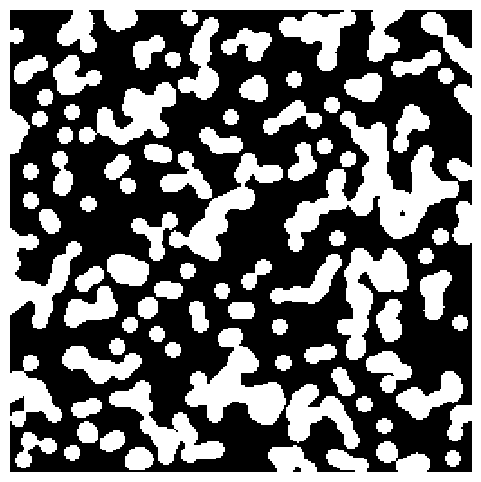

In [22]:
imview(blobs)

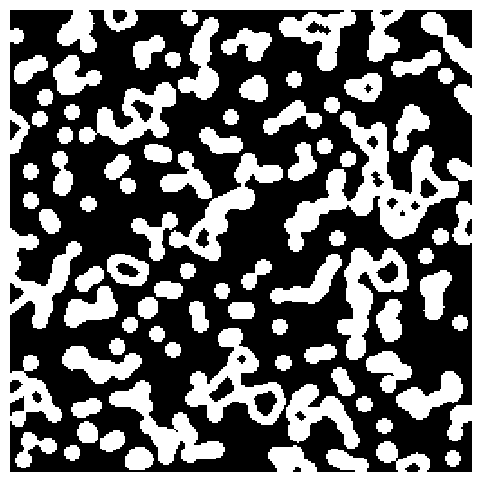

In [24]:
## smaller blobs
from skimage.morphology import erosion,dilation,opening,closing

smallblobs = dilation(erosion(blobs,morphology.disk(7)),morphology.disk(2))

holyblobs = blobs * (1-smallblobs)
imview(holyblobs)

## Binary connected components analysis

- remove the components that touch the border
- fill all the holes
- segment the components (see below)


### border intersection

- construct an image which is zero everywhere except the four borders
- use this image and morphological reconstruction to find the objects that touch the border

- hint: use skimage.morphology.reconstruction

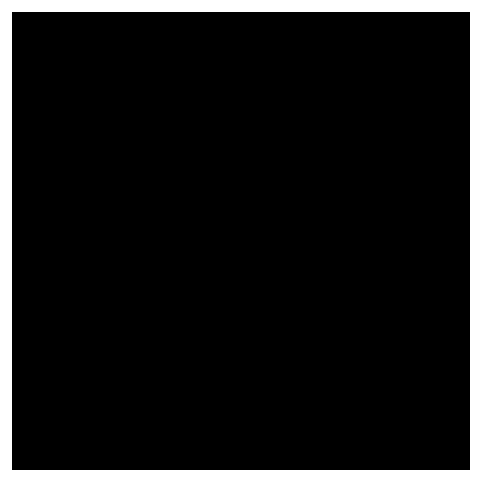

In [25]:
def empty_borders(n):
    im = np.zeros((l,l)).astype(np.uint8)
    im[0,:]=1
    im[:,0]=1
    im[l-1,:]=1
    im[:,l-1]=1
    return(im)
    
borders = empty_borders(n)
imview(borders)

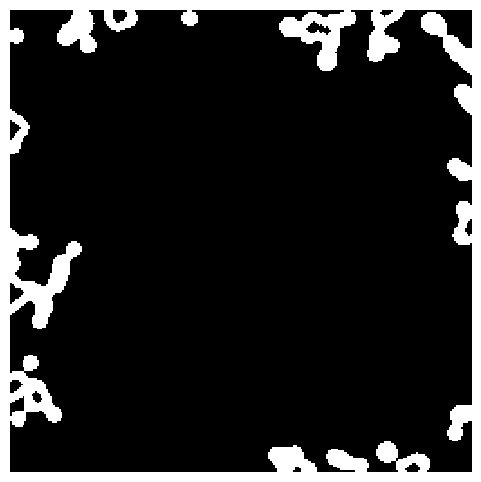

In [26]:
from skimage.morphology import reconstruction

blob_borders = borders * holyblobs
touch_borders = reconstruction(blob_borders,holyblobs)

imview(touch_borders)

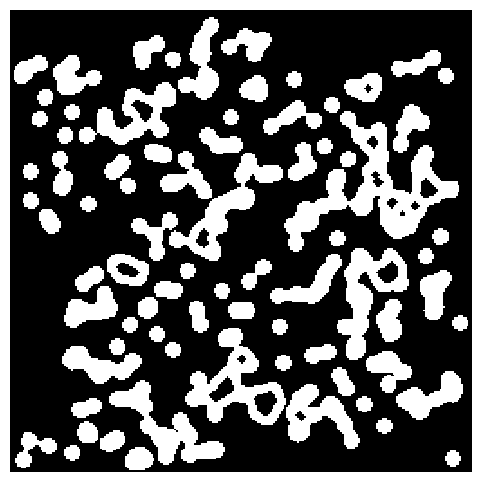

In [27]:
## border objects removed

borderobj_removed = holyblobs - touch_borders
imview(borderobj_removed)

### hole filling

- use the preceeding procedure to fill all the holes of the connected components. 
- hint: holes are connected component of the *background* that do not touch the border of the image.

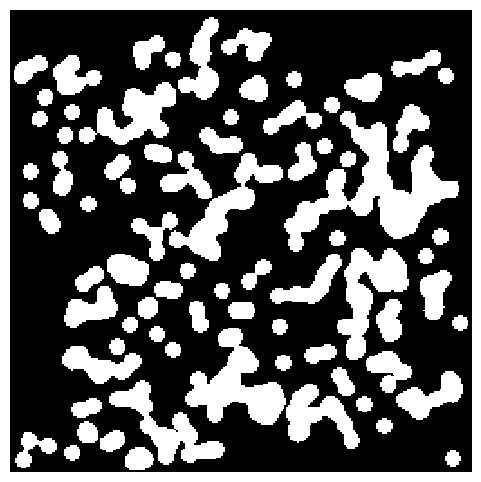

In [28]:
white_holes=1-borderobj_removed

holes_borders = borders * white_holes
holes_borders = reconstruction(holes_borders,white_holes)
## argument selem -> footprint in newer versions of skimage (0.19 and later)

noholes= 1-holes_borders
imview(noholes)

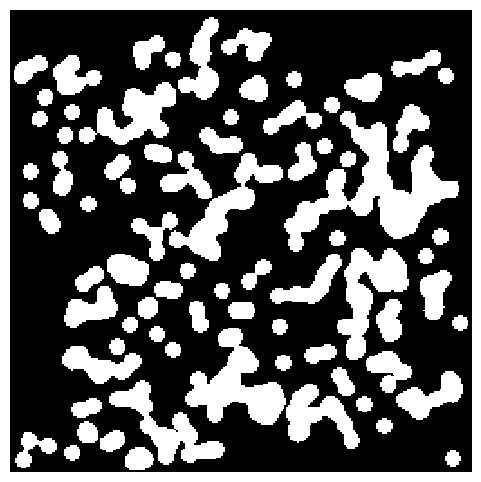

In [29]:
## erosion-based reconstruction
blackborders = 1-borders
blobborders = borderobj_removed * blackborders
holes_borders = reconstruction(blackborders,blobborders,method='erosion')
imview(holes_borders)

## Label all components

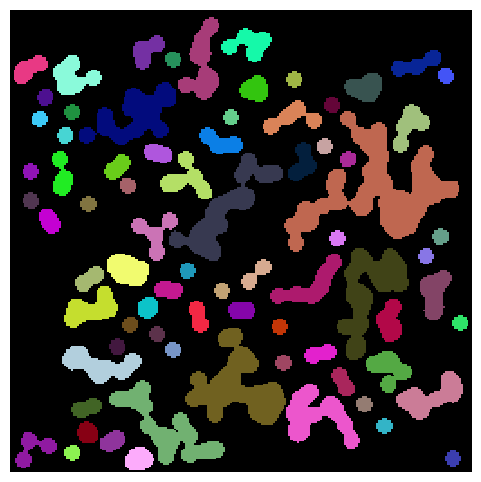

In [30]:
from skimage import measure
all_labels = measure.label(noholes)

imview(all_labels,cmap=randcmap)

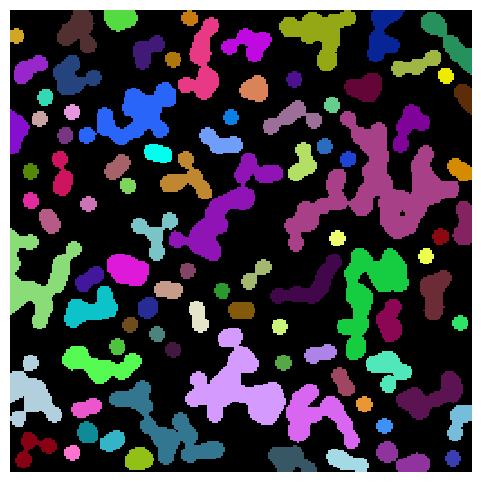

In [31]:
## label only foreground
blobs_labels = measure.label(blobs, background=0)
imview(blobs_labels,cmap=randcmap)

### Séparation d'objets jointifs

Watershed

In [32]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = np.logical_or(mask_circle1, mask_circle2)


# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage

#distance = ndimage.distance_transform_edt(image)
#local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
#markers = morphology.label(local_maxi)
#labels_ws = watershed(-distance, markers, mask=image)

def separate_overlapping_disks(binary_image, min_distance=1):
    distance = ndimage.distance_transform_edt(binary_image)
    local_maxi_coords = peak_local_max(distance, min_distance=min_distance,
                                footprint=np.ones((3, 3)))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(local_maxi_coords.T)] = True
    markers, _ = scipy.ndimage.label(mask)
    #markers = morphology.label(local_maxi_coords)
    labels_ws = watershed(-distance, markers, mask=binary_image)
    return(labels_ws, markers)

labels_ws, markers = separate_overlapping_disks(image)



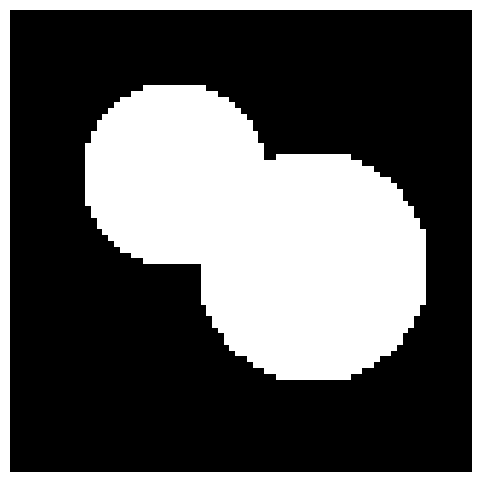

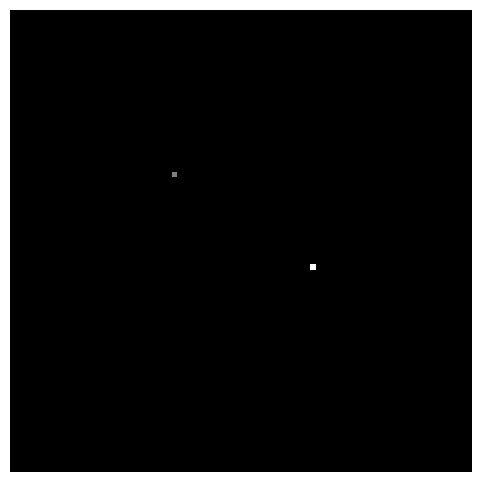

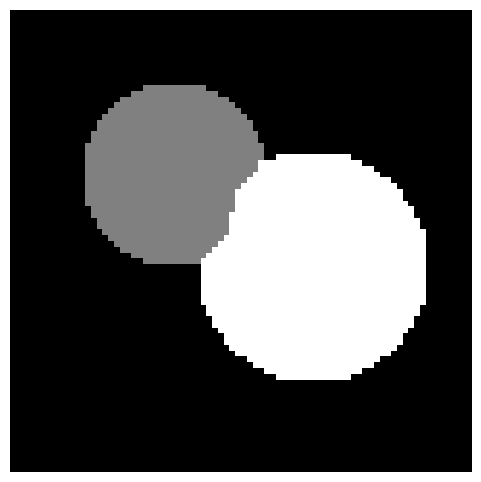

In [33]:
imview(image)
imview(markers)
imview(labels_ws)

## Using the Random Walker instead of the Watershed

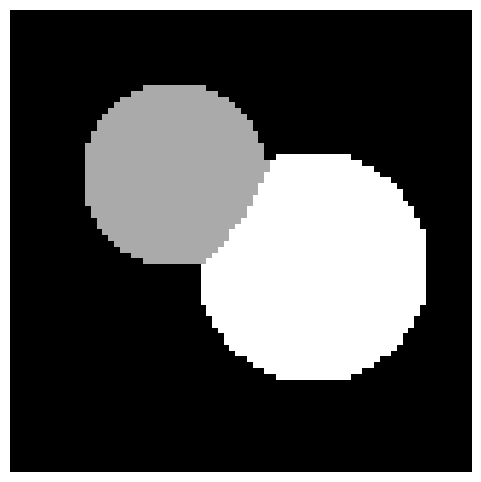

In [34]:
from skimage import segmentation
# Transform markers image so that 0-valued pixels are to
# be labelled, and -1-valued pixels represent background
markers[~image] = -1
labels_rw = segmentation.random_walker(image, markers)

imview(labels_rw)

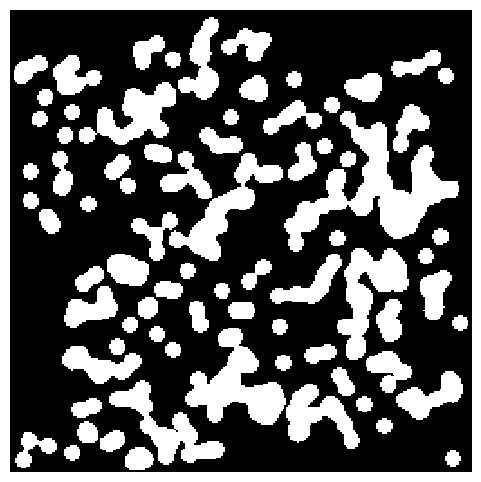

In [35]:
## apply to blogs image

imview(noholes)

separate_blobs, markers = separate_overlapping_disks(noholes)
separate_blobs_filtered, markers = separate_overlapping_disks(noholes,min_distance=7)

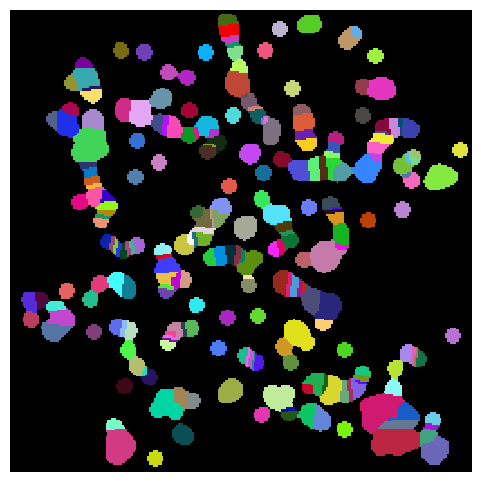

In [30]:
imview(separate_blobs,cmap=randcmap)

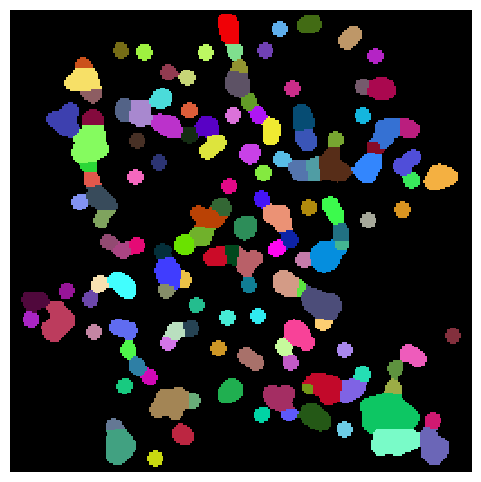

In [31]:
imview(separate_blobs_filtered,cmap=randcmap)

#### Oversegmentation

We see that the blobs are oversegmented, playing with the parameter min_distance allowed us to ameliorate the problem.

## Postprocessing label images

skimage provides several utility functions that can be used on label images (ie images where different discrete values identify different regions). Functions names are often self-explaining: 
- skimage.segmentation.clear_border(), 
- skimage.segmentation.relabel_from_one(), 
- skimage.morphology.remove_small_objects(), 

etc.

In [32]:
## measuring regions properties
from skimage import measure

In [33]:
properties = measure.regionprops(labels_rw)
print("Areas:", [prop.area for prop in properties])
print("Perimeters:",[prop.perimeter for prop in properties])


Areas: [770.0, 1168.0]
Perimeters: [100.91168824543142, 126.81118318204308]


## Exercise 1

- Use the binary image of the coins and background from the previous exercise.
- Compute an image of labels for the different coins.
- Compute the size and eccentricity of all coins.

In [34]:
coins = data.coins()
mask = coins > filters.threshold_otsu(coins)
clean_border = segmentation.clear_border(mask)

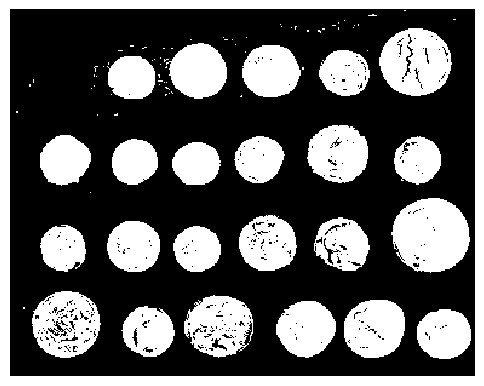

In [35]:
imview(clean_border)

## Exercice 2

- Download an image of _bacillus subtilis_ at 

https://github.com/justinbois/bootcamp/raw/master/data/bsub_100x_cfp.tif

In [36]:
import sys
import urllib.request
import skimage
import skimage.io
# Download the file from `url` and save it locally under `file_name`:

url='https://github.com/justinbois/bootcamp/raw/master/data/bsub_100x_cfp.tif'
filename='bsub_100x_cfp.tif'
with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
        data = response.read() # a `bytes` object
        out_file.write(data)



In [37]:
im_cfp = skimage.io.imread('bsub_100x_CFP.tif')

- remove noise
- segment the bacteria
- plot a histogram of their area

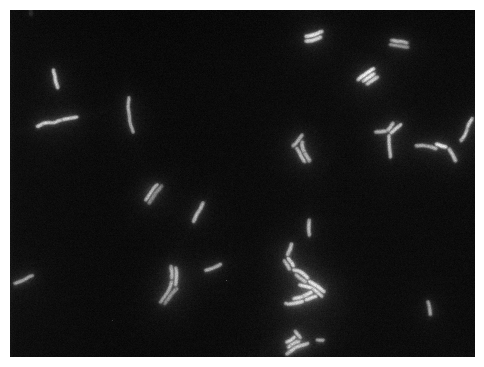

In [38]:
imview(im_cfp)

## Exercice 3 : segmentations des cellules sur l'image des joints

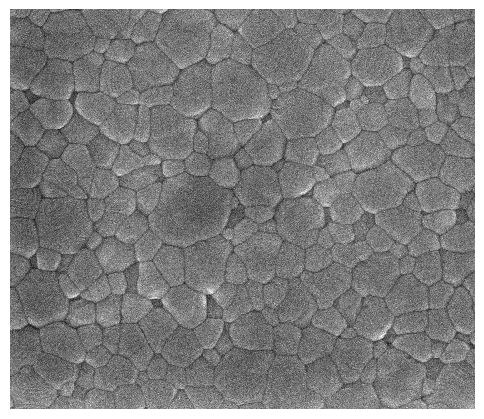

In [39]:
im_joints = skimage.io.imread('grains_crop.png')
imview(im_joints)

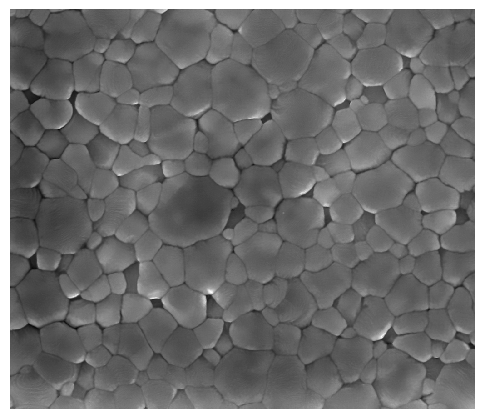

In [40]:
## Denoise the image by Non-Local-Means
from skimage import restoration

im_denoised = restoration.denoise_nl_means(im_joints, h=0.05)
imview(im_denoised)

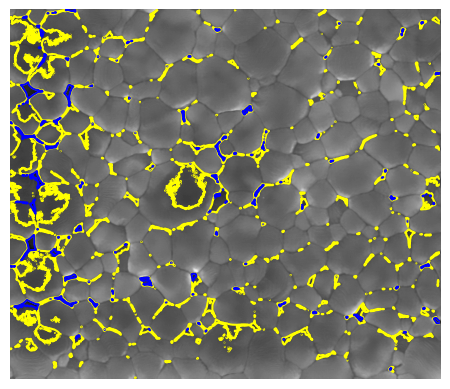

In [41]:
# Try to threshold the image
plt.imshow(im_denoised, cmap='gray')
plt.contour(im_denoised, [0.5], colors='yellow')
plt.contour(im_denoised, [0.45], colors='blue')
ax = plt.axis('off')

This will not work well. Let's try classical contour detection


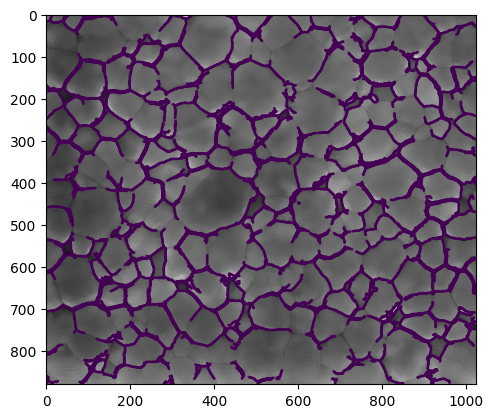

In [42]:
from skimage import feature
edges = feature.canny(im_denoised, sigma=0.2, low_threshold=0.07, \
                      high_threshold=0.18)
plt.imshow(im_denoised, cmap='gray')
plt.contour(edges)

Better but not satisfying

## Trying a semi-automated method (the interactive part does not in a notebook !)

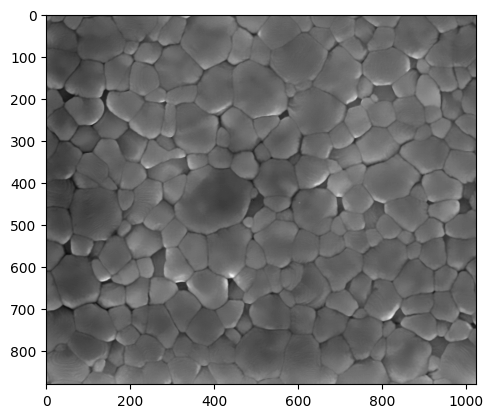

In [43]:
plt.imshow(im_denoised, cmap='gray')

## you will need to try this outside of a notebook, using the Ipython console version
## click_markers = plt.ginput(n=-1, timeout=-1)

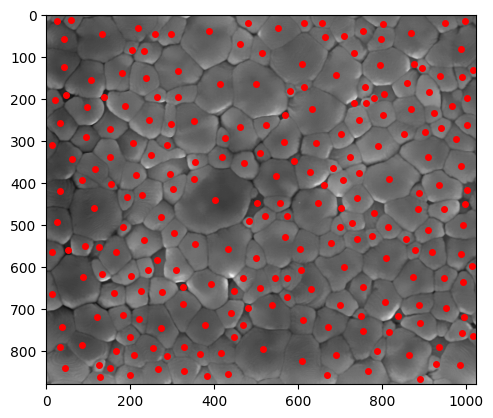

In [44]:
x, y = np.load('indices_markers.npy').T
plt.imshow(im_denoised, cmap='gray')
plt.plot(y, x, 'or', ms=4)

In [45]:
from skimage import morphology
markers = np.zeros(im_denoised.shape, dtype=np.int32)
markers[x.astype(np.int32), y.astype(np.int32)] = np.arange(len(x)) + 1
markers = morphology.dilation(markers, morphology.disk(7))

## Watershed segmentation

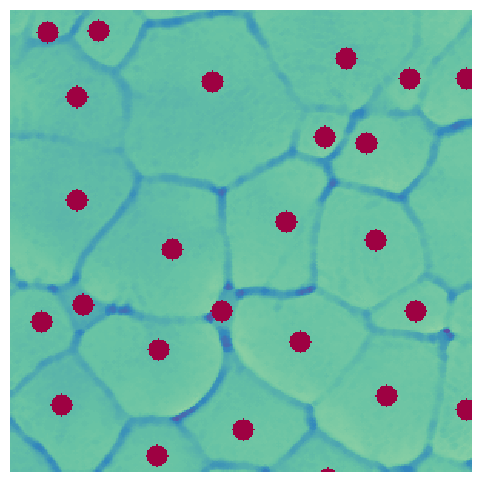

In [46]:
from scipy import ndimage
from skimage import morphology
# Black tophat transformation (see https://en.wikipedia.org/wiki/Top-hat_transform)
hat = ndimage.black_tophat(im_denoised, 7)
# Combine with denoised image
hat -= 0.3 * im_denoised
# Morphological dilation to try to remove some holes in hat image
hat = morphology.dilation(hat)
#imview(hat[:300, :300], cmap='Spectral')
#imview(markers[:300,:300], cmap=randcmap)

markedhat = (hat+1)*(markers==0)
imview(markedhat[:300,:300], cmap='Spectral')

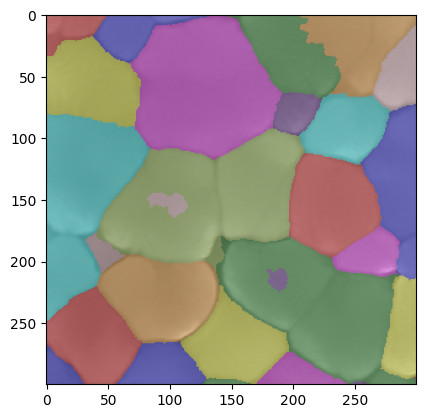

In [47]:
labels_hat = watershed(hat, markers)
from skimage import color
color_labels = color.label2rgb(labels_hat, im_denoised)
plt.imshow(color_labels[:300, :300])

In this result we do have a correct number and positions for the labels but the gradient around them is not always satisfying.

Let's try with a different gradient function.

(-0.5, 299.5, 299.5, -0.5)

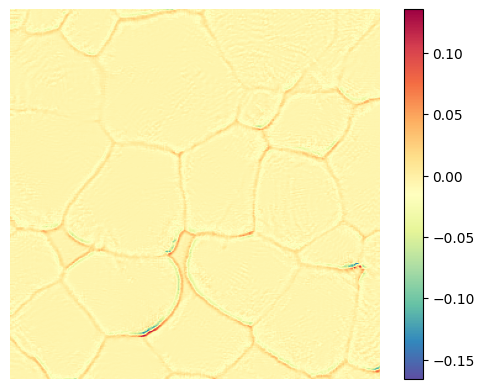

In [48]:
# A different markers image: laplace filter
lap = ndimage.gaussian_laplace(im_denoised, sigma=0.7)
lap = restoration.denoise_nl_means(lap, h=0.002)
plt.imshow(lap[:300, :300], cmap='Spectral_r'); plt.colorbar()
plt.axis('off')

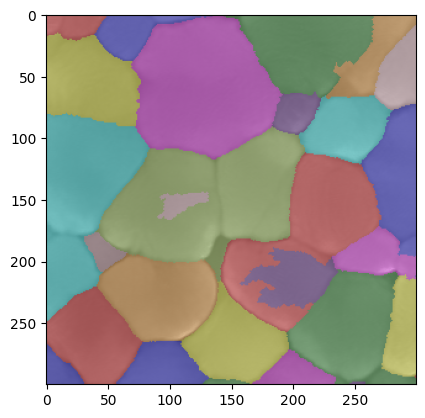

In [49]:
labels_lap = watershed(lap, markers)
color_labels = color.label2rgb(labels_lap, im_denoised)
plt.imshow(color_labels[:300, :300])

The result is different but somewhat similar. Most grain boundaries are well segmented but some are not.

We can try a similar optimisation algorithm for contour placement that is a bit more forgiving to weak gradients.

In [50]:
## construct a smaller sample of labels, because the RW segmentation is linear in the number of labels.
## The colors are such that no two neighboring labels have the same color (i.e like in the 4-colour theorem)
import sklearn

# Graph of nearest neighbors (15 nearest neighbors)
from sklearn.neighbors import kneighbors_graph
mat = kneighbors_graph(np.array([x, y]).T, 15)

# Color the graph using a small number of colors
from pyamg.graph import vertex_coloring
colors = vertex_coloring(mat)
print("Number of colors = ", colors.max(), "; reduced from ", len(x))

# Array of markers
markers_rw = np.zeros(im_denoised.shape, dtype=np.int32)
markers_rw[x.astype(np.int32), y.astype(np.int32)] = colors + 1
markers_rw = morphology.dilation(markers_rw, morphology.disk(5))

Number of colors =  10 ; reduced from  241


In [51]:
## run the segmentation

from skimage import segmentation

## This imports an adaptive multigrid version of the linear Conjugate Gradient algorithm
## it is about 4x faster than the default version
import pyamg

labels_rw = segmentation.random_walker(im_denoised, markers_rw,\
                                       beta=25000, mode='cg_mg')


/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


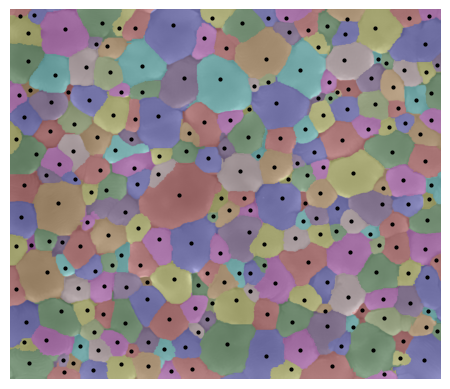

In [52]:
plt.imshow(color.label2rgb(labels_rw, im_denoised,alpha=0.2)) ## blends the label and denoised image
plt.plot(y, x, 'ok', ms=2) ## plots the dots in black
ax = plt.axis('off')

## Stochastic segmentation

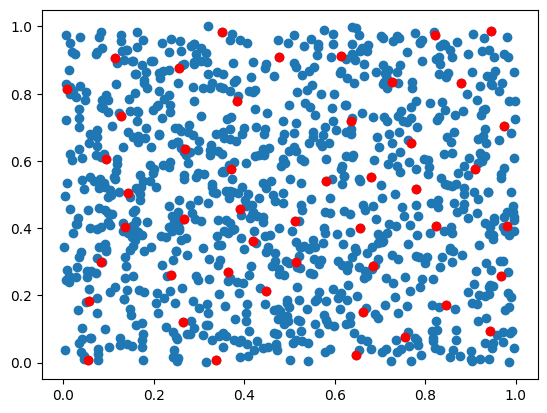

In [53]:
from scipy import spatial

def trim_close_points(points, distance=1):
    """
    Greedy method to remove some points so that
    all points are separated by a distance greater
    than ``distance``.
    
    points : array of shape (2, n_points)
        Coordinates of 2-D points
        
    distance : float
        Minimal distance between points
    """
    x, y = points
    tree = spatial.KDTree(np.array([x, y]).T)
    pairs = tree.query_pairs(distance)
    remove_indices = []
    for pair in pairs:
        if pair[0] in remove_indices:
            continue
        if pair[1] in remove_indices:
            continue
        else:
            remove_indices.append(pair[1])
    keep_indices = np.setdiff1d(np.arange(len(x)), remove_indices)
    return np.array([x[keep_indices], y[keep_indices]])

# Check result on simple example
x, y = np.random.random((2, 1000))
xk, yk = trim_close_points((x, y), 0.1)
plt.plot(x, y, 'o')
plt.plot(xk, yk, 'or')

## Multiple random walkers

Now we perform a large number of random walker segmentations, using different sets of markers. To reduce the computing time, we use a downsampled array here. However, executing the cell below still took 50 minutes on my machine! If you would like to reproduce the results here, you can start from a smaller number of realizations, like 50.

Also, the method of computing segmentations from different sets of markers belongs to the class of embarassingly parallel problems, so that it is easy to parallelize this part. For this purpose, you can use the joblib library, that provide a helper function Parallel for simple parallelization.

In [54]:
from time import time
n_instances = 20
n_markers = 1000
segmentations = []
t1 = time()
for instance in range(n_instances):
    # Random markers
    x, y = np.random.random((2, n_markers))
    x *= im_denoised.shape[0]
    y *= im_denoised.shape[1]
    # Remove points too close to each other
    xk, yk = trim_close_points((x, y), 20)
    mat = kneighbors_graph(np.array([xk, yk]).T, 12)
    colors = vertex_coloring(mat)
    # Array of markers
    markers_rw = np.zeros(im_denoised.shape, dtype=np.int32)
    markers_rw[xk.astype(np.int32), yk.astype(np.int32)] = colors + 1
    markers_rw = morphology.dilation(markers_rw, morphology.disk(3))
    # Segmentation
    labels_rw = segmentation.random_walker(im_denoised[::2, ::2], 
                                           markers_rw[::2, ::2],\
                                       beta=25000, mode='cg_mg')
    segmentations.append(labels_rw)
    print(".", end='')
t2 = time()
print(t2 - t1)

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


.

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


..161.24787187576294


/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


In [55]:
segmentations = np.array(segmentations)
boundaries = np.zeros_like(im_denoised[::2, ::2])
for seg in segmentations:
    boundaries += segmentation.find_boundaries(seg, connectivity=2)

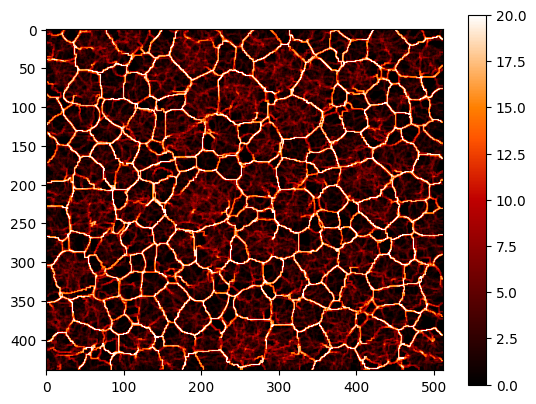

In [56]:
plt.imshow(boundaries, cmap='gist_heat'); plt.colorbar()


In [57]:
def hysteresis_thresholding(im, v_low, v_high):
    """
    Parameters
    ----------
    im : 2-D array
    
    v_low : float
        low threshold
        
    v_high : float
        high threshold
    """
    mask_low = im > v_low
    mask_high = im > v_high
    # Connected components of mask_low
    labels_low = measure.label(mask_low, background=0) + 1
    count = labels_low.max()
    # Check if connected components contain pixels from mask_high
    sums = ndimage.sum(mask_high, labels_low, np.arange(count + 1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums[1:] > 0
    output_mask = good_label[labels_low]
    return output_mask    

In [58]:
from skimage import measure, color


def color_segmentation(regions, n_neighbors=25):
    """
    Reduce the number of labels in a label image to make
    visualization easier.
    """
    count = regions.max()
    centers = ndimage.center_of_mass(regions + 2, regions, 
                                     index=np.arange(1, count + 1))
    centers = np.array(centers)
    mat = kneighbors_graph(np.array(centers), n_neighbors)
    colors = vertex_coloring(mat)
    colors = np.concatenate(([0], colors))
    return colors[regions]                       


def plot_colors(val_low, val_high):
    """
    Plot result of segmentation superimposed on original image,
    and plot original image as well.
    """
    seg = hysteresis_thresholding(boundaries, val_low, val_high)
    regions = measure.label(np.logical_not(seg),
                            background=0, connectivity=1)
    color_regions = color_segmentation(regions)
    colors = [plt.cm.Spectral(val) for val in 
                   np.linspace(0, 1, color_regions.max() + 1)]
    image_label_overlay = color.label2rgb(color_regions, 
                                          im_denoised[::2, ::2],
                                          colors=colors)
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(image_label_overlay)
    plt.subplot(122)
    plt.imshow(im_denoised, cmap='gray')
    return regions

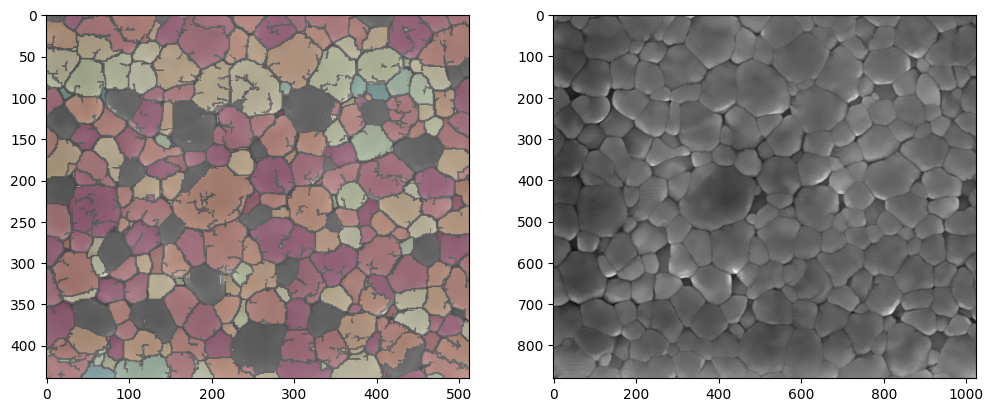

In [78]:
regions = plot_colors(0.3 * n_instances, 0.55 * n_instances)

In order to check the effect of thresholding parameters, we write helper functions that produce meaningful visualizations of the segmentation.

Segmented regions are extracted as connected components in an image where background pixels are the boundaries determined from hysteresis thresholding.

In [63]:
from skimage import measure, color


def color_segmentation(regions, n_neighbors=25):
    """
    Reduce the number of labels in a label image to make
    visualization easier.
    """
    count = regions.max()
    centers = ndimage.center_of_mass(regions + 2, regions, 
                                     index=np.arange(1, count + 1))
    centers = np.array(centers)
    mat = kneighbors_graph(np.array(centers), n_neighbors)
    colors = vertex_coloring(mat)
    colors = np.concatenate(([0], colors))
    return colors[regions]                       


def plot_colors(val_low, val_high):
    """
    Plot result of segmentation superimposed on original image,
    and plot original image as well.
    """
    seg = hysteresis_thresholding(boundaries, val_low, val_high)
    regions = measure.label(np.logical_not(seg),
                            background=0, connectivity=1)
    color_regions = color_segmentation(regions)
    colors = [plt.cm.Spectral(val) for val in 
                   np.linspace(0, 1, color_regions.max() + 1)]
    image_label_overlay = color.label2rgb(color_regions, 
                                          im_denoised[::2, ::2],
                                          colors=colors)
    plt.figure(figsize=(12, 8))
    plt.subplot(121)
    plt.imshow(image_label_overlay)
    plt.subplot(122)
    plt.imshow(im_denoised, cmap='gray')
    return regions

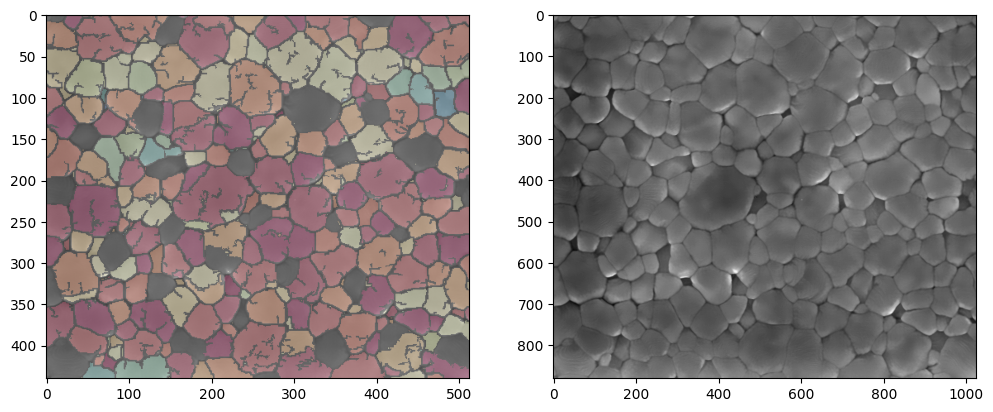

In [64]:
regions = plot_colors(0.3 * n_instances, 0.55 * n_instances)


Once that a good pair of thresholds has been found, it is possible to clean the segmentation by removing small connected components. We relabel labels so that there are no missing labels.

Below, we use a visualization trick so that neighboring regions have different colors: we shuffle labels using np.random.permutation.

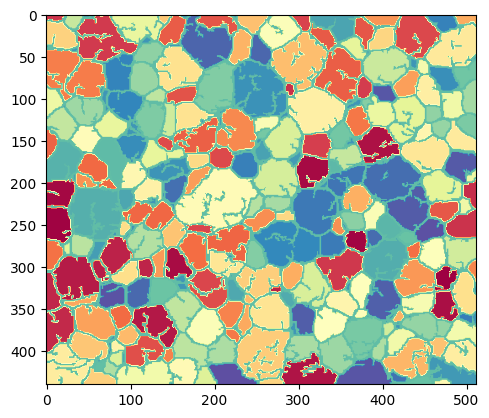

In [65]:
regions_clean = morphology.remove_small_objects(regions + 1, min_size=60)
regions_clean, _, _ = segmentation.relabel_sequential(regions_clean)
plt.imshow(np.random.permutation(regions_clean.max() + 1)[regions_clean],
                   cmap='Spectral')

In order to finish the segmentation and to label pixels that have been labeled as boundaries (some of them being "real boundaries", other not), several possibilities exist, such as using mathematical morphology operations. Here, we'll continue using the random walker to attribute the remaining unknown pixels. We could use the coloring trick again, but since the number of pixels to be determined is small, it is not a big deal not to use it.



In [66]:
final_segmentation = segmentation.random_walker(im_denoised[::2, ::2], 
                                                regions_clean,
                                                beta=25000, mode='cg_mg')

/usr/local/lib/python3.11/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


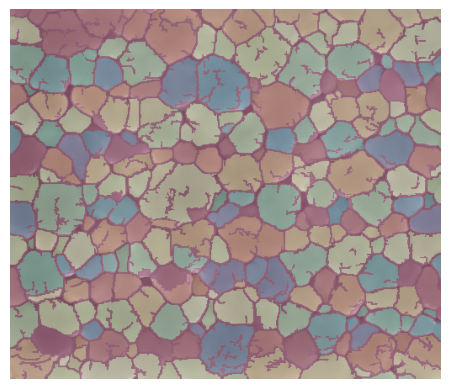

In [68]:
plt.imshow(color.label2rgb(final_segmentation, im_denoised[::2, ::2],
                    colors=plt.cm.Spectral(np.linspace(0, 1, 40))))
ax = plt.axis('off')

We can use different colors if we want to make sure that some pairs of neighboring grains have different labels.

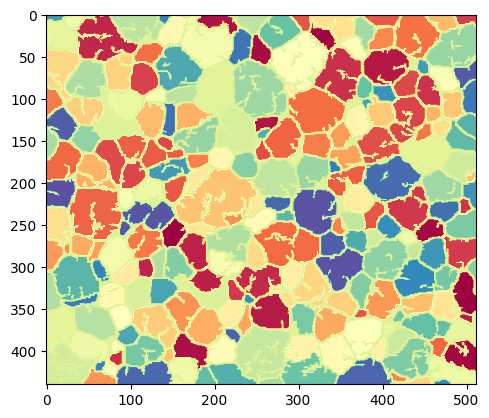

In [69]:
plt.imshow(np.random.permutation(final_segmentation.max() + 1)
                                    [final_segmentation], 
                                    cmap='Spectral')

It was therefore possible to reach a satisfying segmentation in a more automatic way. Depending on your image, it is possible that segmentation from random markers using the watershed algorithm can also result in a good segmentation, in which you can save a lot of time.

Note that it would be possible to improve an automatic segmentation by clicking on a few regions that would not have been segmented correctly, and applying the random walker to these regions.